<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#AB-Testing" data-toc-modified-id="AB-Testing-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>AB-Testing</a></span></li></ul></div>

# AB-Testing

![cats](images/cats.jpeg)


Imaginad que somos los cientificos de datos de la empresa de videojuegos Tactile Entertainment. Los desarrolladores del juego Cookie Cats pretenden introducir un cambio en el juego para aumentar la retencion de los jugadores. En cierto nivel del juego los jugadores se encuentran una puerta que les obliga a esperar o a pagar la app. Actualmente la puerta se encuentra en nivel 30 y se pretende pasar al nivel 40, para comprobar la retencion a 1 y 7 dias. Antes de realizar el cambio definitivo en el juego se raliza un test AB.

Los datos estan alojados en `data/cookie_cats.csv`. Nuestro grupo de control sera la version actual `gate_30` y el grupo de tratamiento sera la version `gate_40`. Debemos realizar el test para 1 dia de retencion `retention_1` y para 7 dias `retention_7`.

In [1]:
# librerias

import pandas as pd
import numpy as np

from statsmodels.stats.proportion import proportions_ztest, proportion_confint
from scipy.stats import norm, sem

import pylab as plt

In [5]:
import warnings
warnings.simplefilter('ignore')

In [12]:
# datos
usuarios = pd.read_csv('data/cookie_cats.csv')
usuarios.head()


,userid,version,sum_gamerounds,retention_1,retention_7
0,116,gate_30,3,False,False
1,337,gate_30,38,True,False
2,377,gate_40,165,True,False
3,483,gate_40,1,False,False
4,488,gate_40,179,True,True


In [14]:
usuarios.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90189 entries, 0 to 90188
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   userid          90189 non-null  int64 
 1   version         90189 non-null  object
 2   sum_gamerounds  90189 non-null  int64 
 3   retention_1     90189 non-null  bool  
 4   retention_7     90189 non-null  bool  
dtypes: bool(2), int64(2), object(1)
memory usage: 2.2+ MB


In [19]:
usuarios.version.value_counts()


gate_40    45489
gate_30    44700
Name: version, dtype: int64

In [34]:
df30=usuarios[usuarios.version=='gate_30']
df30.count()

userid            44700
version           44700
sum_gamerounds    44700
retention_1       44700
retention_7       44700
dtype: int64

In [26]:
df40=usuarios[usuarios.version=='gate_40']
df40.count()

userid            45489
version           45489
sum_gamerounds    45489
retention_1       45489
retention_7       45489
dtype: int64

In [2]:
# transformacion
#agrupamos los datos por el userid

In [35]:
# muestreo


In [43]:
# testeo para retention_1
# retention 30
df30_1=df30[df30.retention_1==True]['retention_1'].sum()   #retención de 1 día
df30_1

#retention 40
df40_1=df40[df40.retention_1==True]['retention_1'].sum()
df40_1


20119

In [44]:
df30_1

20034

In [46]:
df40_1

20119

In [51]:
# testeo para retention_7
# retention 30
df30_7=df30[df30.retention_7==True]['retention_7'].sum()

# retention 40
df40_7=df40[df40.retention_7==True]['retention_7'].sum()


In [49]:
df30_7  #control 7 días

8502

In [53]:
df40_7  # test 7 días

8279

In [66]:
#EMPIEZO OTRA VEZ
#Esto de Yona. Hay que adaptarlo a 2
#1_día
imps_30_1, convs_ctrl1 = 44700, 20034   # entrar, esperar
imps_40_1, convs_test1= 45489, 20119

CR_ctrl = convs_ctrl1/imps_30_1
CR_test = convs_test1/imps_40_1


f'TASAS: Control={CR_ctrl}, Test={CR_test}'

'TASAS: Control=0.4481879194630872, Test=0.44228274967574577'

In [65]:
# 7_días

imps_30_7, convs_ctrl7 = 44700, 8502   # entrar, esperar
imps_40_7, convs_test7= 45489, 8279

CR_ctr7 = convs_ctrl7/imps_30_7
CR_test7 = convs_test7/imps_40_7

f'TASAS: Control={CR_ctr7}, Test={CR_test7}'

'TASAS: Control=0.19020134228187918, Test=0.18200004396667327'

In [69]:
#Los a prioris 1_día

treinta_C_1, cuarenta_C_1 = convs_ctrl1+1, imps_30_1-convs_ctrl1+1   #control
treinta_T_1, cuarenta_T_1 = imps_40_1+1, imps_40_1-convs_test+1   #test


In [68]:
#Los a prioris 7_día
treinta_C_7, cuarenta_C_7 = convs_ctrl+1, imps_30_1-convs_ctrl+1    #control
treinta_T_7, cuarenta_T_7 = imps_40_1+1, imps_40_1-convs_test7+1    #Test


In [70]:
print(treinta_C_1, cuarenta_C_1 )   #esto es día 1 control de 30 a 40 
print(treinta_T_1, cuarenta_T_1)    #esto es día 1 test de 30 a 40

20035 24667
45490 25371


In [72]:
print(treinta_C_7, cuarenta_C_7)    #esto es día 7 control de 30 a 40
print(treinta_T_7, cuarenta_T_7)    #esto es día 7 test de 30 a 40

20035 24667
45490 37211


In [61]:
beta_control=beta(treinta_C, cuarenta_C)   #Se ponen los controles. 30
beta_test=beta(treinta_T, cuarenta_T)     #Se ponen los test. 40



In [74]:
# a prioris de 1 

a_C, b_C = convs_ctrl1 +1, imps_30_1-convs_ctrl1 +1
a_T, b_T = convs_test1 +1, imps_40_1-convs_test1 +1

beta_control=beta(a_C, b_C)
beta_test=beta(a_T, b_T)


In [75]:
#a prioris de 7

a_C_7, b_C_7 = convs_ctrl7 +1, imps_30_7-convs_ctrl7 +1
a_T_7, b_T_7 = convs_test7 +1, imps_40_7-convs_test7 +1

beta_control7=beta(a_C_7, b_C_7)
beta_test7=beta(a_T_7, b_T_7)

In [ ]:
#medias

In [76]:
beta_control.mean(), beta_test.mean()   #de 1

(0.44819023757326293, 0.44228528719966587)

In [77]:
beta_control7.mean(), beta_test7.mean()   # de 7

(0.19021520289919913, 0.18201402475214878)

In [ ]:
#Dibujar

In [78]:
x=np.linspace(0, 0.008, 1000)

def plot(betas, nombres):
    
    for bet, nom in zip(betas, nombres):
        
        y=bet.pdf(x)
        y_media=bet.mean()
        y_std=bet.std()
        
        plt.plot(x, y, label='{}, tasa de conv: {:.6f} $\pm$ {:.10f}'.format(nom, y_media, y_std))
        plt.yticks([])
        
    plt.legend()
    plt.show()
    
    

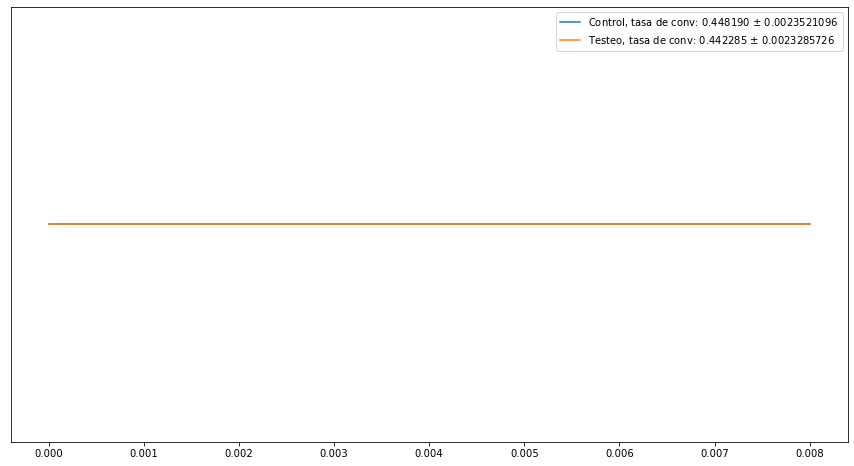

In [87]:
plot([beta_control, beta_test], ['Control', 'Testeo'])


In [88]:
print (CR_ctrl, CR_test)
plot([beta_C, beta_T], ['Control', 'Test'])

0.4481879194630872 0.44228274967574577


NameError: name 'beta_C' is not defined